<a href="https://colab.research.google.com/github/ayulockin/deepimageimpainting/blob/master/Image_Inpainting_Autoencoder_decoder_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Installations and Imports

In [1]:
!pip install tensorflow-gpu==2.0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0


In [2]:
!pip install wandb -q

In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.12.0


In [4]:
import wandb
from wandb.keras import WandbCallback

#!wandb login 69f60a7711ce6b8bbae91ac6d15e45d6b1f1430e

In [5]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

# Prepare Dataset

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


#### Visualization of Cifar 10

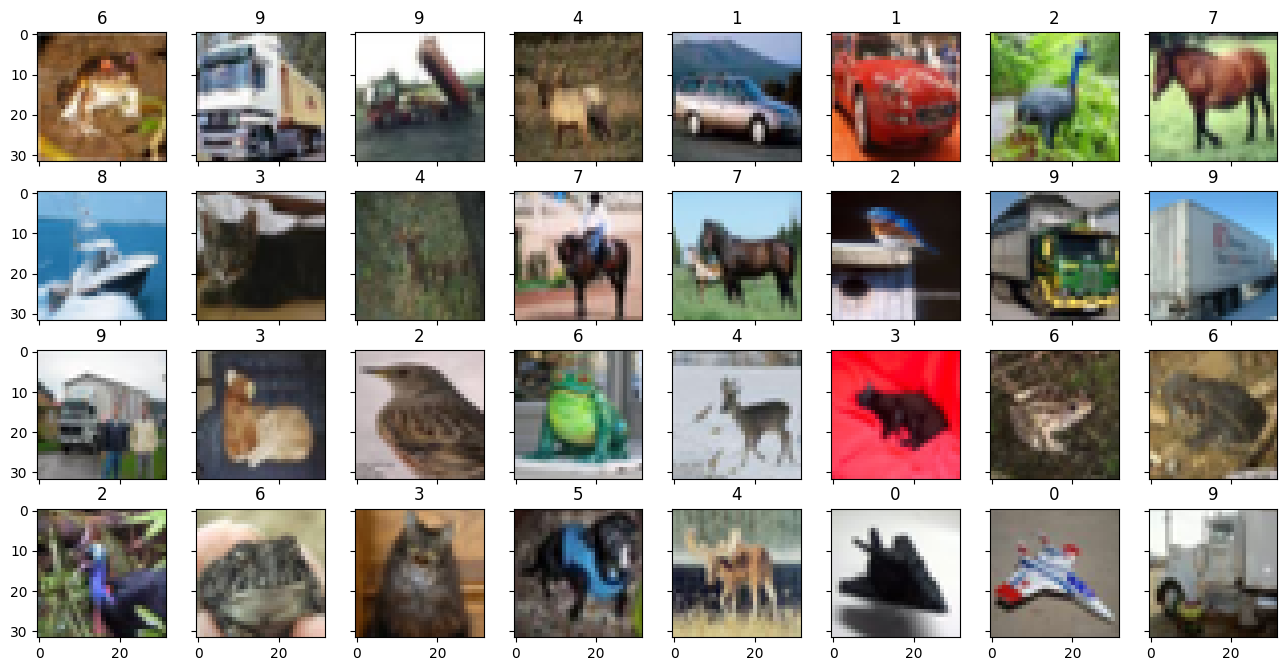

In [7]:
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

#### Data Generator with Patch Augmentation

In [1]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size
      self.y = y
      self.X = X
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle == True:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
      X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
      y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))

      x = y = np.random.randint(0, 31, 1)[0]
      w = h = np.random.randint(1, 10, 1)[0]

      for i, idx in enumerate(idxs):
        tmp_image = self.X[idx].copy()

        mask = np.full(tmp_image.shape, 255, np.uint8)
        mask[y:y+h,x:x+w] = 0
        res = cv2.bitwise_and(tmp_image, mask)

        X_batch[i,] = res/255
        y_batch[i] = self.y[idx]/255
        
      return X_batch, y_batch

NameError: name 'keras' is not defined

In [9]:
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test)

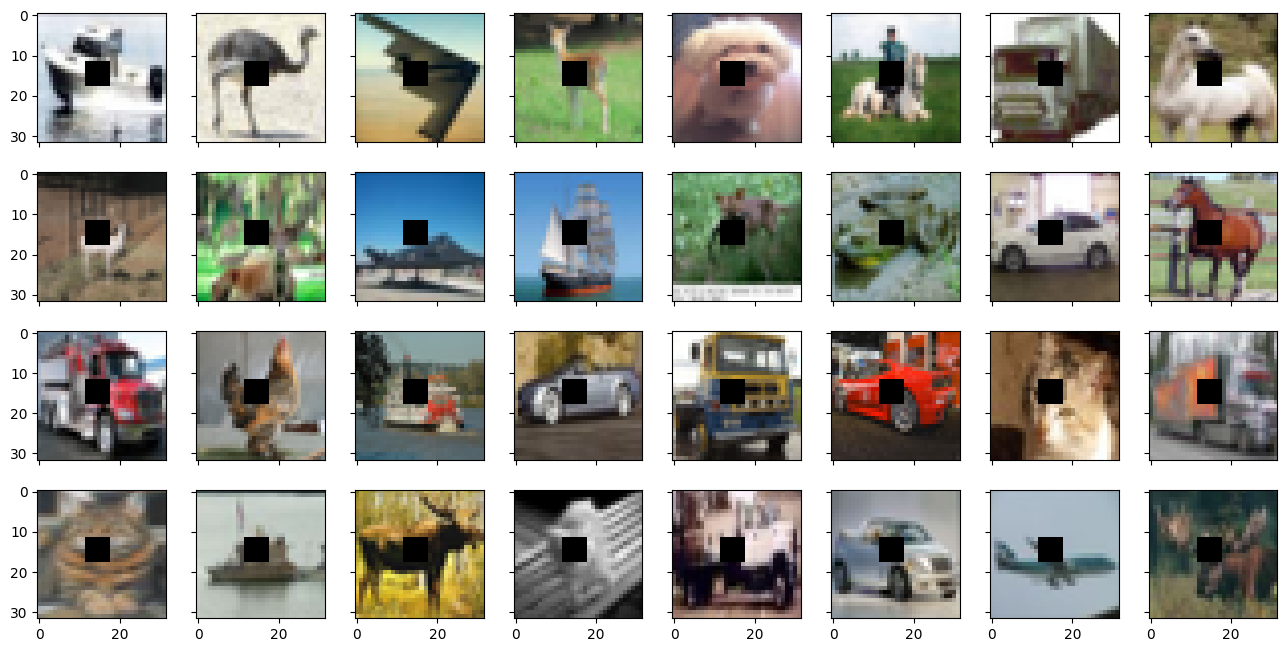

In [18]:
## Examples
sample_idx = 100 ## Change this to see different batches

sample_images, sample_labels = traingen[sample_idx]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

## Autoencoder-Decoder Model

In [21]:
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + 1)

In [20]:
def unet_like():
  inputs = keras.layers.Input((32, 32, 3))
  conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
  pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
  pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
  conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

  up6 = keras.layers.concatenate([keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
  conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
  conv6 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
  up7 = keras.layers.concatenate([keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
  conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
  conv7 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
  up8 = keras.layers.concatenate([keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
  conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
  conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
  up9 = keras.layers.concatenate([keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
  conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
  conv9 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
  conv10 = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

  return keras.models.Model(inputs=[inputs], outputs=[conv10]) 


def unet_simple():
    inputs = keras.layers.Input((32, 32, 3))
    
    # Encoding / Downsampling
    conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    # Decoding / Upsampling
    up4 = keras.layers.concatenate([keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=3)
    conv4 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up4)

    up5 = keras.layers.concatenate([keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4), conv1], axis=3)
    conv5 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up5)

    # Output
    outputs = keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(conv5)

    return keras.models.Model(inputs=[inputs], outputs=[outputs]) 

In [22]:
keras.backend.clear_session()
model = unet_simple()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['max_pooling2d[0][0]']          
                 

# Train

In [17]:
#wandb.init(entity='ayush-thakur', project="image-impainting")
# wandb.init(project="test-inpainting")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ayush-thakur. Use `wandb login --relogin` to force relogin


In [23]:
model.fit(traingen, validation_data=testgen, 
          epochs=5, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True)

Epoch 1/5


2023-05-13 18:11:05.436174: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/yf9/miniconda3/envs/myenv/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/yf9/miniconda3/envs/myenv/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'createAugment' on <module '__main__' (built-in)>


# Testing on images

In [ ]:
model.save('impaint_trail1.h5')

In [ ]:
im = sample_images[0]
impainted_image = model.predict(im.reshape((1,)+im.shape))

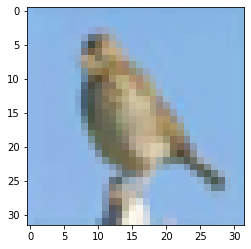

In [23]:
plt.imshow(impainted_image.reshape(impainted_image.shape[1:]))

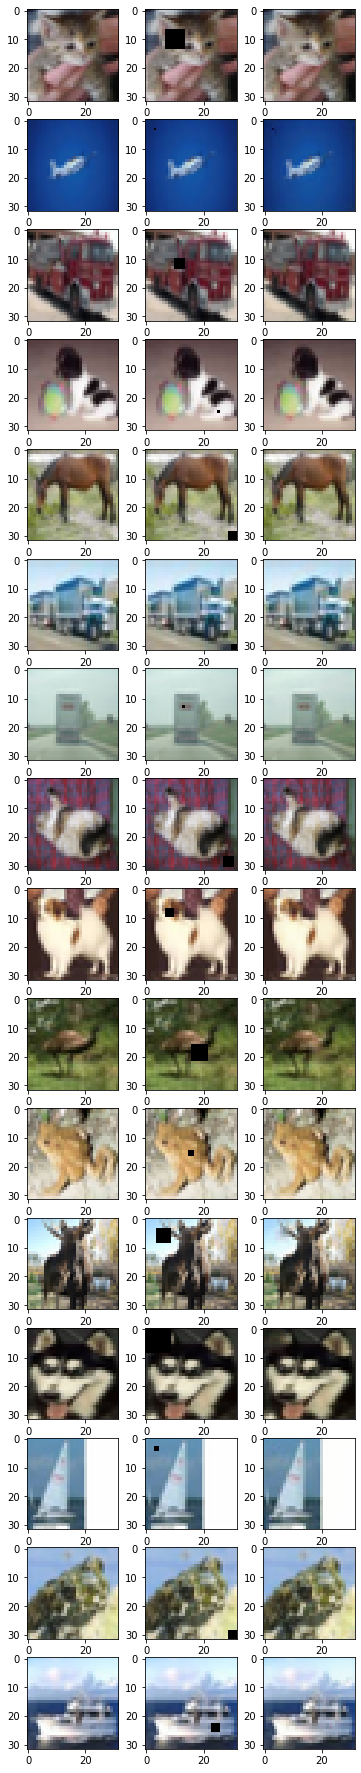

In [27]:
## Examples
rows = 16
sample_idx = np.random.randint(0, len(testgen), rows)

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 32))

for i, idx in enumerate(sample_idx):
  sample_images, sample_labels = traingen[idx]
  img_idx = np.random.randint(0, len(sample_images)-1, 1)[0]
  impainted_image = model.predict(sample_images[img_idx].reshape((1,)+sample_images[img_idx].shape))
  axs[i][0].imshow(sample_labels[img_idx])
  axs[i][1].imshow(sample_images[img_idx])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()